This notebook demonstrates correlations between the legitimacy of candidates and the RB scores of their candidates $\textbf{IT DOESN'T SEEM TO BE WORKING YET}$

For S.3.7, let's start with the R/B. Three histograms (in a row, g-r-i) of the R/B scores for all sources detected (ever) in COSMOS and ELAIS. Then in the row below, perhaps histograms of the average R/B scores for all candidates with at least 3 detections in a given filter in one night (i.e., likely reals). This will give us an immediate comparison of R/B values for "all detections" and "all real candidates".

In [1]:
import psycopg2
import psycopg2.extras
import getpass
from IPython.display import display
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl

# Custom
from decam_utils import *

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")

DB User:  kennedyt
DB Password:  ············


In [3]:
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

In [4]:
db.autocommit = True # Makes the computer nicer about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

In [5]:
font = {'size'   : 15}

mpl.rc('font', **font)

In [6]:
# def rm_dupes( arr, ecols=None ):
#     """
#     Removes duplicate rows from a numpy array. Has functionality to exclude some column(s) from the duplicate-finding process.
#     For the purposes of the DECam DDF notebooks, that should be the index of the object ID column, if your array includes it, and left \
#     blank if not. For best results, make sure your array includes candidate id, R/B score, and something to tie it to a specific 
#     exposure (fnm, eid, etc.)
    
#     Takes:
#     arr : the original array with some duplicate rows
#     ecols : index/indices of excluded columns. NOTE: no matter what this index is, it will be the first column of res
    
#     Returns:
#     res : the original array with the duplicate rows removed
#     """
#     if ecols == None:
#         dupes = arr
#     else:
#         dupes = np.delete(arr, ecols, axis=0)
#     dupes = np.array( [" ".join(i) for i in dupes.transpose()] )
#     unique, ind = np.unique( dupes, return_index=True )
#     uarr = np.array( [ i.split(" ") for i in unique ] ).transpose()
#     if ecols == None:
#         res = uarr
#     else:
#         res = np.append( [arr[ecols][ind]], uarr, axis=0 )
#     print( "%s duplicates removed" % ( len( arr[0] ) - len( res[0] ) ) )
#     return res

### Top Panel

In [7]:
# Pulling in all the detections ever from both COSMOS and ELIAS
query = ( 'SELECT o.id, o.rb, o.candidate_id, e.filter, e.mjd, e.filename FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) '
         'AND e.mjd < 59377 ' 
         'LIMIT 10000000' )

cursor.execute( query )

COSMOSrbquery = np.array( cursor.fetchall() ).transpose()

query = ( 'SELECT o.id, o.rb, o.candidate_id, e.filter, e.mjd, e.filename FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON s.exposure_id=e.id '
         'WHERE q3c_radial_query(o.ra,o.dec,8.5,-43.5,2) '
         'AND e.mjd < 59377 ' 
         'LIMIT 10000000' )

cursor.execute( query )

ELIASrbquery = np.array( cursor.fetchall() ).transpose()

In [8]:
# Eliminating dupes (COSMOS & ELIAS)
Cres = rm_dupes( COSMOSrbquery, 0 )
Eres = rm_dupes( ELIASrbquery, 0 )

94155 duplicates removed
1140 duplicates removed


In [9]:
# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)


# truncate filenames to match lookup table format (COSMOS)
Cfnms = [ Cres[5][i][:21] for i in range( len( Cres[5] ) ) ]
# find the exposure time for each object
Cexptimes = np.array([exptable[np.where(Cfnms[i] == fnmtable)[0]][0] for i in range(len(Cfnms))], dtype=float)

# truncate filenames to match lookup table format (ELIAS)
Efnms = [ Eres[5][i][:21] for i in range( len( Eres[5] ) ) ]
# find the exposure time for each object
Eexptimes = np.array([exptable[np.where(Efnms[i] == fnmtable)[0]][0] for i in range(len(Efnms))], dtype=float)

In [10]:
# Eliminate nonstandard exposure times (COSMOS)
Cfilters = Cres[3]
gmsk = np.where((Cfilters=="g") & (Cexptimes>50))[0]
rmsk = np.where((Cfilters=="r") & (Cexptimes>20))[0]
imsk = np.where((Cfilters=="i") & (Cexptimes>20))[0]

# Combine and apply the standard images masks (COSMOS)
grmsk = np.append(rmsk, gmsk)
Cgrimsk = np.append(grmsk, imsk)
Cres = [i[Cgrimsk] for i in Cres]

# Eliminate nonstandard exposure times (ELIAS)
Efilters = Eres[3]
gmsk = np.where((Efilters=="g") & (Eexptimes>50))[0]
rmsk = np.where((Efilters=="r") & (Eexptimes>20))[0]
imsk = np.where((Efilters=="i") & (Eexptimes>20))[0]

# Combine and apply the standard images masks (ELIAS)
grmsk = np.append(rmsk, gmsk)
Egrimsk = np.append(grmsk, imsk)
Eres = [i[Egrimsk] for i in Eres]

In [11]:
# Create lists of rb scores in g, r, and i for both COSMOS and ELIAS, store in Crbs and Erbs
Cgmsk = np.where(Cres[3] == "g")[0]
Crmsk = np.where(Cres[3] == "r")[0]
Cimsk = np.where(Cres[3] == "i")[0]
Crbs = [Cres[1][Cgmsk].astype(float),
        Cres[1][Crmsk].astype(float),
        Cres[1][Cimsk].astype(float)]

Egmsk = np.where(Eres[3] == "g")[0]
Ermsk = np.where(Eres[3] == "r")[0]
Eimsk = np.where(Eres[3] == "i")[0]
Erbs = [Eres[1][Egmsk].astype(float),
        Eres[1][Ermsk].astype(float),
        Eres[1][Eimsk].astype(float)]

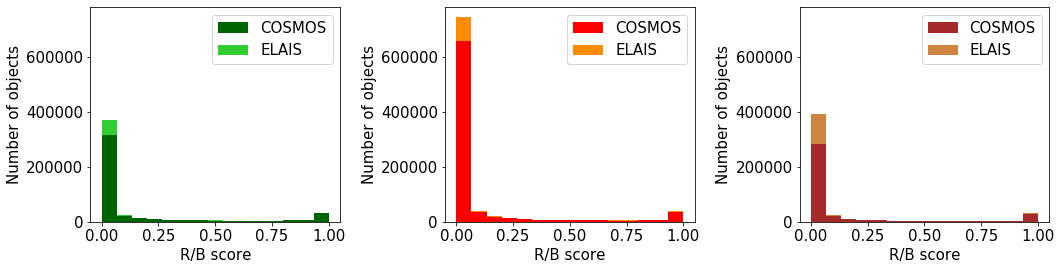

In [12]:
# Create bins to be applied on all three plots
bins = np.histogram(Crbs[0], bins=15)[1]

# Plot it all up
c = ['darkgreen', 'red', 'brown', 'limegreen', 'darkorange', 'peru']
fig, ax = plt.subplots( 1,3,figsize=(15,4), sharey=True )

for i in [0,1,2]:
    ax[i].yaxis.set_tick_params(which='both', labelbottom=True)
    ax[i].hist( [Crbs[i],Erbs[i]], bins, stacked=True, color=[c[i],c[i+3]], label=['COSMOS','ELAIS'])
    ax[i].legend()
    ax[i].set_ylabel("Number of objects")
    ax[i].set_xlabel("R/B score")
fig.tight_layout()
plt.savefig("./images/RBvobjsCOSMOS.png")

### Bottom Panel

In [13]:
x = [] # An array to store the names of candidates that pass the test

for f in [Cgmsk, Crmsk, Cimsk]: # Looping through filters (just COSMOS for now)
    # Grab the rounded nights, candidates, and a list of unique candidates in a given filter
    Crnights = np.round( Cres[4][f].astype(float) )
    Ccands = Cres[2][f]
    Cucands = np.unique(Cres[2][f])
    
    # Get a list of every observing night
    unights = np.unique( Crnights )

    # Make a list of every candidate (including repeats) detected in each night
    arr = [ Ccands[ Crnights == i ] for i in unights ]

    # Create newarr, an array of arrays (one per night) that contain
    #       0) The names of all candidates detected that night (no repeats)
    #       1) The mask used to create (0) from arr[i]
    #       2) The number of times each candidate was detected on that night
    newarr = [ np.array( np.unique( i, return_index=True, return_counts = True) ) for i in arr ]
    # Pull out the components
    cands = [i[0] for i in newarr]
    indices = [i[1] for i in newarr]
    cts = [i[2] for i in newarr]
    # Make a list of every candidate that was detected at least 3 times in a night in the given filter (f)
    newnewarr = [ cands[i][ np.where(cts[i].astype(int) > 2)[0] ] for i in range(len(newarr)) ]
    # Add all of those candidate's names to x
    for i in newnewarr:
        x.extend(i)

# This results in some duplicates, so remove them
goodcands = np.unique(x)
# And we have a list of every candidate that was detected at least 3 times in a given filter in one night

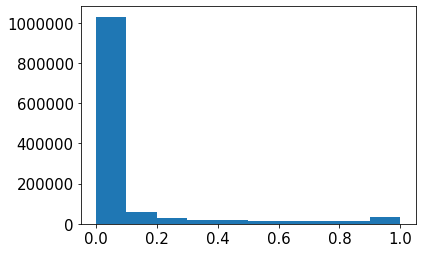

In [14]:
# Pick out every R/B value corresponding to one of these candidates and put them into a histogram
msk = np.isin( Cres[2], goodcands )
plt.hist( Cres[1][msk].astype(float) );

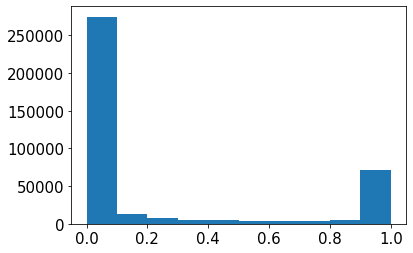

In [15]:
# Curiously, this seems to do better if we take only the candidates that did not pass the test
msk = np.isin( Cres[2], goodcands, invert=True )
plt.hist( Cres[1][msk].astype(float) );

In [16]:
### Some test subjects (from the SNsearch notebook) that should (and do) pass the test
# g = ['DC21bcpi', 'DC21bicq', 'DC21bkrj', 'DC21bpls', 'DC21cove',
#        'DC21cxou', 'DC21dhgr', 'DC21dqf', 'DC21dqik', 'DC21dtwb',
#        'DC21eqq', 'DC21fber', 'DC21homb', 'DC21hunj', 'DC21ixp',
#        'DC21kgy', 'DC21kog', 'DC21ktp', 'DC21kxb', 'DC21url']

# for i in g:
#     print(i in goodcands)
# [i for i in g if i not in goodcands]